In [1]:
import sys
print(sys.executable)  # Εμφανίζει το path του Python interpreter
print(sys.version)     # Εμφανίζει την έκδοση της Python
import torch            # Εισαγωγή της βιβλιοθήκης PyTorch
import random
import numpy as np
import torch

# --- Συνάρτηση για σταθεροποίηση τυχαίων αριθμών ---
def set_seed(seed=42):
    random.seed(seed)                  # Python random
    np.random.seed(seed)               # NumPy random
    torch.manual_seed(seed)            # PyTorch CPU
    torch.cuda.manual_seed(seed)       # PyTorch GPU
    torch.cuda.manual_seed_all(seed)   # Όλες οι διαθέσιμες GPUs

    # --- Επιβεβαίωση deterministic behavior για reproducibility ---
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Ορισμός seed για reproducibility ---
set_seed(42)


c:\Users\dimia\AppData\Local\Programs\Python\Python313\python.exe
3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]


In [2]:
from medmnist import BloodMNIST  # Εισαγωγή του dataset BloodMNIST από τη βιβλιοθήκη MedMNIST
print(torch.__version__)         # Εμφανίζει την έκδοση του PyTorch
print(torch.cuda.is_available()) # Ελέγχει αν υπάρχει διαθέσιμη GPU (True) ή μόνο CPU (False)

2.9.1+cpu
False


In [3]:
train_dataset = BloodMNIST(split="train",download=True)  # Φόρτωση του training dataset, κατεβάζει αν δεν υπάρχει
X_train = train_dataset.imgs   # Αποθήκευση των εικόνων του training set
y_train = train_dataset.labels # Αποθήκευση των labels του training set

test_dataset = BloodMNIST(split="test",download=True)    # Φόρτωση του test dataset
X_test = test_dataset.imgs     # Αποθήκευση των εικόνων του test set
y_test = test_dataset.labels   # Αποθήκευση των labels του test set

val_dataset = BloodMNIST(split="val",download=True)      # Φόρτωση του validation dataset
X_val = val_dataset.imgs       # Αποθήκευση των εικόνων του validation set
y_val = val_dataset.labels     # Αποθήκευση των labels του validation set


In [4]:
class DatasetIterator(torch.utils.data.Dataset):
    def __init__(
        self,
        features,
        labels
    ):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):

        x = self.features[idx].astype('float32') 
        y = self.labels[idx]

        return x, y

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Ορισμός της συσκευής: GPU αν υπάρχει, αλλιώς CPU

import torch.nn as nn               # Εισαγωγή των layers του PyTorch
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # Ρύθμιση του backend του matplotlib για inline plots σε notebook
import matplotlib.pyplot as plt     # Εισαγωγή του matplotlib για γραφήματα
import torch.optim as optimizer     # Εισαγωγή του optimizer module
import torch.nn.functional as F    # Εισαγωγή συναρτήσεων ενεργοποίησης, loss κ.λπ.

train_iterator = DatasetIterator(X_train, y_train)  # Δημιουργία iterator για training set
test_iterator = DatasetIterator(X_test, y_test)     # Δημιουργία iterator για test set
val_iterator = DatasetIterator(X_val, y_val)        # Δημιουργία iterator για validation set

# Transpose των εικόνων από (N,H,W,C) σε (N,C,H,W) για PyTorch Conv2d
X_train = X_train.transpose(0, 3, 1, 2)
X_test = X_test.transpose(0, 3, 1, 2)
X_val = X_val.transpose(0, 3, 1, 2)

# Μετατροπή σε torch tensors και τύπο float32 για εικόνες
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train = X_train.to(device)                    # Μεταφορά στο επιλεγμένο device
y_train = torch.tensor(y_train, dtype=torch.long).to(device)  # Μετατροπή labels σε long και στο device

X_test = torch.tensor(X_test, dtype=torch.float32)
X_test = X_test.to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

X_val = torch.tensor(X_val, dtype=torch.float32)
X_val = X_val.to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


In [6]:
class CnnNet(nn.Module):
    def __init__(self,ConvLayer1,ConvLayer2,ConvLayer3,
                 ConvSize1,ConvSize2,ConvSize3,
                 Hidden1,Hidden2,Hidden3,
                 PoolStride,PoolSize):

        super(CnnNet,self).__init__()

        # --- Ορισμός των Conv layers ---
        self.conv1 = nn.Conv2d(3,ConvLayer1,ConvSize1,stride=1)   # Conv layer από 3 κανάλια εισόδου
        self.conv2 = nn.Conv2d(ConvLayer1,ConvLayer2,ConvSize2,stride=1)
        self.conv3 = nn.Conv2d(ConvLayer2,ConvLayer3,ConvSize3,stride=1)

        # --- Batch Normalization για κάθε Conv layer ---
        self.bn1 = nn.BatchNorm2d(ConvLayer1)
        self.bn2 = nn.BatchNorm2d(ConvLayer2)
        self.bn3 = nn.BatchNorm2d(ConvLayer3)

        # --- Pooling layers ---
        self.pool = nn.MaxPool2d(PoolSize,PoolStride)   # Max pooling
        self.pool2 = nn.AvgPool2d(PoolSize,1)           # Average pooling με stride 1

        # --- Flatten για fully connected layers ---
        self.flat = nn.Flatten()

        # --- Αυτοματοποιημένος υπολογισμός size του flatten ---
        dummy = torch.zeros(1, 3, 28, 28)  # dummy input για μέτρηση
        dummy = self.pool(F.relu(self.bn1(self.conv1(dummy))))
        dummy = self.pool(F.relu(self.bn2(self.conv2(dummy))))
        dummy = self.pool2(F.relu(self.bn3(self.conv3(dummy))))
        flatten_size = dummy.numel()        # συνολικός αριθμός στοιχείων μετά το flatten

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(flatten_size, Hidden2)
        self.fc2 = nn.Linear(Hidden2, Hidden3)
        self.fc3 = nn.Linear(Hidden3, 8)    # Τελική έξοδος 8 classes

    def forward(self,x):

        # --- Forward pass μέσα από τα conv layers ---
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))

        # --- Flatten για FC layers ---
        x = self.flat(x)

        # --- Forward pass μέσα από fully connected layers ---
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)  # σχόλιο για πιθανή χρήση dropout
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)  # σχόλιο για πιθανή χρήση dropout
        x = self.fc3(x)        # Τελική έξοδος logits για 8 κλάσεις

        return x



In [7]:
class CnnNet2(nn.Module):
    def __init__(self,ConvLayer1,ConvLayer2,ConvLayer3,
                 ConvSize1,ConvSize2,ConvSize3,
                 Hidden1,Hidden2,Hidden3,
                 PoolStride,PoolSize):

        super(CnnNet2,self).__init__()

        # --- Ορισμός Conv layers ---
        self.conv1 = nn.Conv2d(3,ConvLayer1,ConvSize1,stride=1)
        self.conv2 = nn.Conv2d(ConvLayer1,ConvLayer2,ConvSize2,stride=1)
        self.conv3 = nn.Conv2d(ConvLayer2,ConvLayer3,ConvSize3,stride=1)

        # --- Batch Normalization για κάθε Conv layer ---
        self.bn1 = nn.BatchNorm2d(ConvLayer1)
        self.bn2 = nn.BatchNorm2d(ConvLayer2)
        self.bn3 = nn.BatchNorm2d(ConvLayer3)

        # --- Pooling layers ---
        self.pool = nn.MaxPool2d(PoolSize,PoolStride)
        self.pool2 = nn.AvgPool2d(PoolSize,1)

        # --- Dropout για regularization ---
        self.dropout1 = nn.Dropout(p=0.485)  # Dropout μετά το πρώτο FC
        #self.dropout2 = nn.Dropout(p=0.04) # Δε χρησιμοποιείται προς το παρόν

        # --- Flatten για fully connected layers ---
        self.flat = nn.Flatten()

        # --- Αυτοματοποιημένος υπολογισμός flatten size ---
        dummy = torch.zeros(1, 3, 28, 28)
        dummy = self.pool(F.relu(self.bn1(self.conv1(dummy))))
        dummy = self.pool(F.relu(self.bn2(self.conv2(dummy))))
        dummy = self.pool2(F.relu(self.bn3(self.conv3(dummy))))
        flatten_size = dummy.numel()

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(flatten_size, Hidden2)
        self.fc2 = nn.Linear(Hidden2, Hidden3)
        self.fc3 = nn.Linear(Hidden3, 8)  # Τελική έξοδος 8 classes

    def forward(self,x):

        # --- Forward pass μέσα από Conv layers ---
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))

        # --- Flatten για FC layers ---
        x = self.flat(x)

        # --- Fully connected layers με ReLU και dropout ---
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)   # Dropout για regularization
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)  # Dropout μη ενεργό
        x = self.fc3(x)         # Τελική έξοδος logits

        return x


In [8]:
class CnnNet3(nn.Module):
    def __init__(self,ConvLayer1,ConvLayer2,ConvLayer3,
                 ConvSize1,ConvSize2,ConvSize3,
                 Hidden1,Hidden2,Hidden3,
                 PoolStride,PoolSize):

        super(CnnNet3,self).__init__()

        # --- Ορισμός Conv layers ---
        self.conv1 = nn.Conv2d(3,ConvLayer1,ConvSize1,stride=1)
        self.conv2 = nn.Conv2d(ConvLayer1,ConvLayer2,ConvSize2,stride=1)
        self.conv3 = nn.Conv2d(ConvLayer2,ConvLayer3,ConvSize3,stride=1)

        # --- Batch Normalization για κάθε Conv layer ---
        self.bn1 = nn.BatchNorm2d(ConvLayer1)
        self.bn2 = nn.BatchNorm2d(ConvLayer2)
        self.bn3 = nn.BatchNorm2d(ConvLayer3)

        # --- Pooling layer ---
        self.pool = nn.MaxPool2d(PoolSize,PoolStride)
        self.pool = nn.MaxPool2d(PoolSize,2)  

        # --- Dropout layers (απενεργοποιημένα προς το παρόν) ---
        #self.dropout1 = nn.Dropout(p=0.05)
        #self.dropout2 = nn.Dropout(p=0.04)

        # --- Flatten για fully connected layers ---
        self.flat = nn.Flatten()

        # --- Αυτοματοποιημένος υπολογισμός flatten size ---
        dummy = torch.zeros(1, 3, 28, 28)
        dummy = self.pool(F.relu(self.bn1(self.conv1(dummy))))
        dummy = self.pool(F.relu(self.bn2(self.conv2(dummy))))
        dummy = self.pool(F.relu(self.bn3(self.conv3(dummy))))
        flatten_size = dummy.numel()

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(flatten_size, Hidden2)
        self.fc2 = nn.Linear(Hidden2, Hidden3)
        self.fc3 = nn.Linear(Hidden3, 8)  # Τελική έξοδος 8 classes

    def forward(self,x):

        # --- Forward pass μέσα από Conv layers ---
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # --- Flatten για FC layers ---
        x = self.flat(x)

        # --- Fully connected layers με ReLU ---
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)  # Dropout απενεργοποιημένο
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)  # Dropout απενεργοποιημένο
        x = self.fc3(x)         # Τελική έξοδος logits

        return x


In [9]:
class CnnNet1(nn.Module):
    def __init__(self,ConvLayer1,ConvLayer2,ConvLayer3,
                 ConvSize1,ConvSize2,ConvSize3,
                 Hidden1,Hidden2,Hidden3,
                 PoolStride,PoolSize):

        super(CnnNet1,self).__init__()

        # --- Ορισμός Conv layers και BatchNorm ---
        self.conv1 = nn.Conv2d(3,ConvLayer1,ConvSize1,stride=1)
        self.bn1   = nn.BatchNorm2d(ConvLayer1)

        self.conv2 = nn.Conv2d(ConvLayer1,ConvLayer2,ConvSize2,stride=1)
        self.bn2   = nn.BatchNorm2d(ConvLayer2)

        self.conv3 = nn.Conv2d(ConvLayer2,ConvLayer3,ConvSize3,stride=1)
        self.bn3   = nn.BatchNorm2d(ConvLayer3)

        # --- Pooling layers ---
        self.pool  = nn.MaxPool2d(PoolSize,PoolStride)
        self.pool2 = nn.AvgPool2d(PoolSize,1)

        # --- Projection για skip connection ---
        self.proj = nn.Conv2d(3, ConvLayer3, kernel_size=1)

        # --- Flatten για fully connected layers ---
        self.flat = nn.Flatten()

        # --- Αυτοματοποιημένος υπολογισμός flatten size με residual ---
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 28, 28)
            identity = dummy

            # Forward μέσα από conv + pool
            out = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            out = self.pool(F.relu(self.bn2(self.conv2(out))))
            out = self.bn3(self.conv3(out))

            # Προσαρμογή identity μέσω projection και interpolation
            identity = self.proj(torch.nn.functional.interpolate(
                identity, size=out.shape[2:]
            ))

            # Προσθήκη residual
            out = out + identity
            out = self.pool2(F.relu(out))

            flatten_size = out.numel()

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(flatten_size, Hidden2)
        self.fc2 = nn.Linear(Hidden2, Hidden3)
        self.fc3 = nn.Linear(Hidden3, 8)  # Τελική έξοδος 8 classes

    def forward(self,x):

        # --- Residual forward pass ---
        identity = x
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.bn3(self.conv3(x))

        # Προσαρμογή identity για residual connection
        identity = self.proj(F.interpolate(identity, size=x.shape[2:]))
        x = x + identity
        x = self.pool2(F.relu(x))

        # --- Flatten και fully connected layers ---
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Τελική έξοδος logits

        return x


In [10]:
model = CnnNet3(16,32,64,3,2,2,84,128,48,2,2).to(device)  
# Δημιουργία του μοντέλου CnnNet3 με συγκεκριμένα channel sizes και fully connected layers, μεταφορά στο device (CPU/GPU)

learning_rate = 0.001

# --- Ορισμός διαφορετικών optimizers ---
optim_adam = optimizer.Adam(model.parameters(), lr=learning_rate, weight_decay=1*1e-4)  
optim_sgd = optimizer.SGD(model.parameters(), lr=0.0007, weight_decay=1.95*1e-5)  
optim_rms = optimizer.RMSprop(model.parameters(), lr=0.001, alpha=0.985, eps=1e-9, weight_decay=1e-6, momentum=0.2)  
optim_nes = optimizer.NAdam(model.parameters(), lr=0.00075, betas=(0.9,0.9995), eps=1e-9, momentum_decay=0.005, weight_decay=2*1e-5)  
optim_ran = optimizer.RAdam(model.parameters(), lr=0.001, weight_decay=1e-5, betas=(0.9,0.9995))  

criterion = nn.CrossEntropyLoss()  
# Ορισμός της συνάρτησης κόστους για multi-class classification

# --- Ορισμός scheduler που μειώνει το learning rate όταν η validation loss κολλάει ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
        optimizer = optim_adam,   # Ο optimizer που θα επηρεαστεί
        min_lr = 1e-6,            # Ελάχιστο LR
        mode = "min",              # Παρακολουθείται το min (π.χ. validation loss)
        factor = 0.6,              # Ποσοστό μείωσης LR
        patience = 4,              # Πόσες εποχές περιμένει πριν μειώσει το LR
        threshold = 0.007          # Τιμή αλλαγής για να θεωρηθεί improvement
)


In [11]:
def training_loop(Model, Optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, criterion ,scheduling):    

    history = []                # Λίστα για την αποθήκευση training loss ανά εποχή
    accuracys_training = []     # Λίστα για την αποθήκευση training accuracy ανά εποχή
    accuracys_validation = []   # Λίστα για την αποθήκευση validation accuracy ανά εποχή
    val_loss_history = []       # Λίστα για την αποθήκευση validation loss ανά εποχή
    n_samples = len(X_train)    # Αριθμός δειγμάτων στο training set
    
    for epoch in range(epochs):
        permutation = torch.randperm(n_samples)  # Τυχαία αναδιάταξη των δειγμάτων για κάθε εποχή
        total_loss = 0

        # --- Training loop ανά batch ---
        for i in range(0, n_samples, batch_size):
            indices = permutation[i:i+batch_size]  # Επιλογή batch
            X_batch = X_train[indices]
            y_batch = y_train[indices]

            outputs = Model(X_batch)               # Forward pass
            loss = criterion(outputs, y_batch[:,0])  # Υπολογισμός loss
            Optimizer.zero_grad()                  # Μηδενισμός gradients
            loss.backward()                        # Backpropagation
            Optimizer.step()                       # Ενημέρωση weights

            total_loss += loss.item()              # Άθροιση loss για την εποχή

        # --- Υπολογισμός training accuracy ---
        with torch.no_grad():
            outputs_train = Model(X_train)
            predictions_train = torch.argmax(outputs_train, dim=1)
            accuracy_t = (predictions_train == y_train[:,0]).float().mean()

        # --- Υπολογισμός validation loss και accuracy ---
        with torch.no_grad():
            outputs_val = Model(X_val)
            val_loss = criterion(outputs_val, y_val[:,0]).item()
            predictions_val = torch.argmax(outputs_val, dim=1)
            accuracy_v = (predictions_val == y_val[:,0]).float().mean()
            
        # --- Scheduler step με βάση validation loss ---
        if scheduling != None :
            scheduling.step(val_loss)

        # --- Αποθήκευση ιστορικού ---
        history.append(total_loss / (n_samples // batch_size))  # Μέσο loss ανά batch
        val_loss_history.append(val_loss)
        accuracys_training.append(accuracy_t.item())
        accuracys_validation.append(accuracy_v.item())

        # --- Εκτύπωση αποτελεσμάτων για κάθε εποχή ---
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {history[-1]:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {accuracy_t:.4f}, Val Acc: {accuracy_v:.4f}")

    # Επιστροφή ιστορικού για plotting ή ανάλυση
    return history, val_loss_history, accuracys_training, accuracys_validation


In [12]:
history,val_loss,accracys_training,accracys_validation=training_loop(Model=model,Optimizer=optim_adam,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,epochs=100,batch_size=64,criterion=criterion,scheduling=None)

Epoch [1/100], Loss: 0.6874, Val Loss: 0.3738, Train Acc: 0.8684, Val Acc: 0.8674
Epoch [2/100], Loss: 0.3674, Val Loss: 0.3154, Train Acc: 0.8891, Val Acc: 0.8791
Epoch [3/100], Loss: 0.2850, Val Loss: 0.2826, Train Acc: 0.9104, Val Acc: 0.8949
Epoch [4/100], Loss: 0.2403, Val Loss: 0.2246, Train Acc: 0.9327, Val Acc: 0.9229
Epoch [5/100], Loss: 0.2044, Val Loss: 0.2521, Train Acc: 0.9297, Val Acc: 0.9130
Epoch [6/100], Loss: 0.1892, Val Loss: 0.2284, Train Acc: 0.9398, Val Acc: 0.9317
Epoch [7/100], Loss: 0.1703, Val Loss: 0.1976, Train Acc: 0.9560, Val Acc: 0.9287
Epoch [8/100], Loss: 0.1475, Val Loss: 0.1788, Train Acc: 0.9642, Val Acc: 0.9381
Epoch [9/100], Loss: 0.1322, Val Loss: 0.2083, Train Acc: 0.9628, Val Acc: 0.9252
Epoch [10/100], Loss: 0.1305, Val Loss: 0.2400, Train Acc: 0.9533, Val Acc: 0.9229
Epoch [11/100], Loss: 0.1210, Val Loss: 0.1673, Train Acc: 0.9766, Val Acc: 0.9468
Epoch [12/100], Loss: 0.0987, Val Loss: 0.2006, Train Acc: 0.9729, Val Acc: 0.9334
Epoch [13/100

In [13]:
import numpy as np

def metrics(model,X_test,y_test):
  model.eval()  # Θέτει το μοντέλο σε evaluation mode (π.χ. απενεργοποιεί dropout)
  accuracy_test=0
  num_classes=8

  with torch.no_grad():  # Απενεργοποιεί το gradient computation
    outputs = model(X_test)                        # Forward pass στο test set
    predictions = torch.argmax(outputs, dim=1)     # Επιλογή κλάσης με μέγιστη πιθανότητα
    accuracy_test = (predictions == y_test[:,0]).float().mean()  # Υπολογισμός accuracy

  confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int32)  # Αρχικοποίηση confusion matrix

  # --- Γέμισμα του πίνακα ---
  for i in range(len(y_test)):
    true_label = int(y_test[i, 0])
    pred_label = int(predictions[i])
    confusion_matrix[true_label, pred_label] += 1   # Στήλες = προβλέψεις, γραμμές = πραγματικές κλάσεις

  # --- Μετατροπή σε numpy ---
  cm1 = confusion_matrix.numpy()
  cm = confusion_matrix.numpy().astype(float)
  num_classes = cm.shape[0]

  precision = np.zeros(num_classes)
  recall = np.zeros(num_classes)
  f1 = np.zeros(num_classes)

  # --- Υπολογισμός precision, recall, F1 για κάθε κλάση ---
  for i in range(num_classes):
    TP = cm[i, i]                      # True Positives
    FP = cm[:, i].sum() - TP            # False Positives
    FN = cm[i, :].sum() - TP            # False Negatives

    precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

  # --- Εκτύπωση metrics ανά κλάση ---
  for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

  return accuracy_test, cm1  # Επιστροφή συνολικού accuracy και confusion matrix

Class 0: Precision=0.894, Recall=0.865, F1=0.879
Class 1: Precision=0.997, Recall=0.962, F1=0.979
Class 2: Precision=0.930, Recall=0.942, F1=0.936
Class 3: Precision=0.839, Recall=0.870, F1=0.854
Class 4: Precision=0.963, Recall=0.868, F1=0.913
Class 5: Precision=0.872, Recall=0.842, F1=0.857
Class 6: Precision=0.920, Recall=0.968, F1=0.944
Class 7: Precision=0.989, Recall=0.996, F1=0.993
Test Accuracy: 92.69%


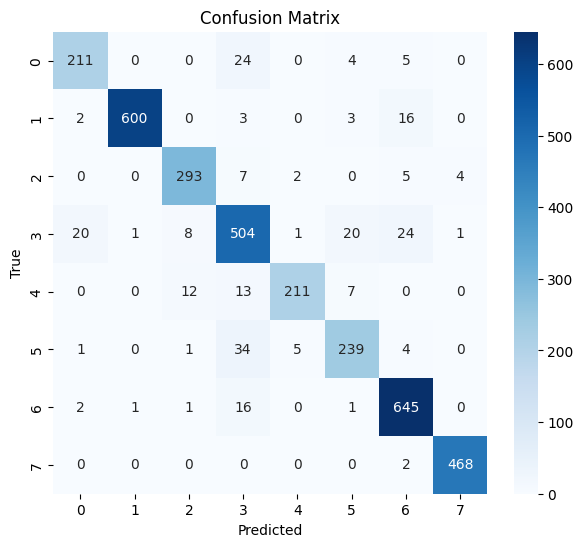

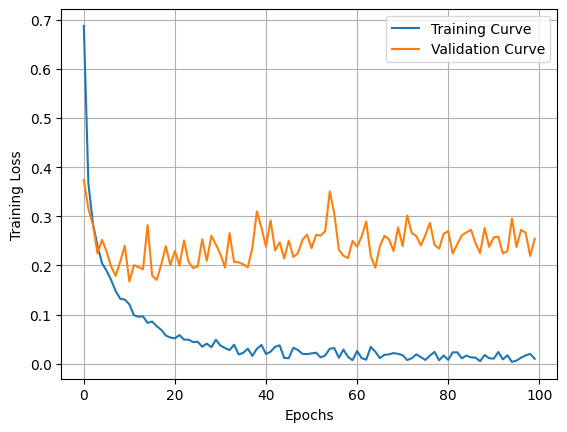

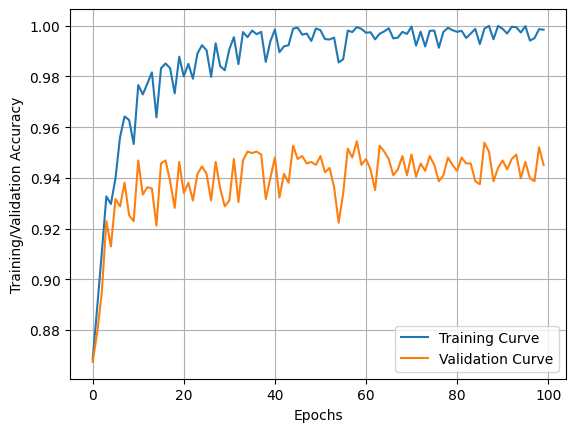

In [14]:
import seaborn as sns

# --- Υπολογισμός metrics για το test set ---
accuracy_score, cm = metrics(model, X_test, y_test)  
print(f"Test Accuracy: {accuracy_score * 100:.2f}%")  # Εκτύπωση συνολικού accuracy σε ποσοστό

# --- Plot Confusion Matrix ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Χρωματιστό heatmap με αριθμούς
plt.xlabel("Predicted")  # Άξονας x = προβλέψεις
plt.ylabel("True")       # Άξονας y = πραγματικές κλάσεις
plt.title("Confusion Matrix")
plt.show()

# --- Plot Training / Validation Loss ---
plt.figure()
plt.plot(history)       # Training loss
plt.plot(val_loss)      # Validation loss
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# --- Plot Training / Validation Accuracy ---
plt.figure()
plt.plot(accracys_training)   # Training accuracy
plt.plot(accracys_validation) # Validation accuracy
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training/Validation Accuracy')
plt.grid(True)
plt.show()


In [15]:
params = {
    "lr": [0.0005, 0.001, 0.0001],
    "weight_rl": [1e-4, 1e-5, 1e-6]
}

cv = 5
n_samples = len(X_train)

# --- ΣΤΑΘΕΡΟ SHUFFLE ΜΙΑ ΦΟΡΑ ---
indices = torch.randperm(n_samples)

X_shuffled = X_train[indices]
y_shuffled = y_train[indices]

fold_size = n_samples // cv

mean_acc = np.zeros((len(params["lr"]), len(params["weight_rl"])))

# --- GRID SEARCH ---
for i, lr in enumerate(params["lr"]):
    for j, wd in enumerate(params["weight_rl"]):

        fold_accuracies = []

        # --- K-FOLD CV ---
        for k in range(cv):
            start = k * fold_size
            end = (k + 1) * fold_size if k != cv - 1 else n_samples

            # validation fold
            X_val_fold = X_shuffled[start:end]
            y_val_fold = y_shuffled[start:end]

            # training folds
            X_train_fold = torch.cat((X_shuffled[:start], X_shuffled[end:]))
            y_train_fold = torch.cat((y_shuffled[:start], y_shuffled[end:]))

            # --- ΝΕΟ ΜΟΝΤΕΛΟ ---
            model1 = CnnNet3(
                16, 32, 64,
                3, 2, 2,
                84, 128, 48,
                2, 2
            ).to(device)

            optimizer_adam = torch.optim.Adam(
                model1.parameters(),
                lr=lr,
                weight_decay=wd
            )

            # --- TRAIN ---
            training_loop(
                Model=model1,
                Optimizer=optimizer_adam,
                X_train=X_train_fold,
                y_train=y_train_fold,
                X_val=X_val_fold,
                y_val=y_val_fold,
                epochs=10,
                batch_size=64,
                criterion=criterion,
                scheduling=None
            )

            # --- VALIDATION ACC ---
            acc, _ = metrics(model1, X_val_fold, y_val_fold)
            fold_accuracies.append(acc.item())

        # --- ΜΕΣΗ ACCURACY ---
        mean_acc[i, j] = np.mean(fold_accuracies)

        print(
            f"lr={lr}, wd={wd} -> "
            f"mean CV accuracy = {mean_acc[i, j]:.4f}"
        )


Epoch [1/10], Loss: 0.9270, Val Loss: 0.4556, Train Acc: 0.8386, Val Acc: 0.8478
Epoch [2/10], Loss: 0.4275, Val Loss: 0.3815, Train Acc: 0.8691, Val Acc: 0.8578
Epoch [3/10], Loss: 0.3260, Val Loss: 0.3204, Train Acc: 0.8950, Val Acc: 0.8762
Epoch [4/10], Loss: 0.2711, Val Loss: 0.2574, Train Acc: 0.9253, Val Acc: 0.9055
Epoch [5/10], Loss: 0.2313, Val Loss: 0.2345, Train Acc: 0.9391, Val Acc: 0.9193
Epoch [6/10], Loss: 0.2023, Val Loss: 0.2500, Train Acc: 0.9346, Val Acc: 0.9130
Epoch [7/10], Loss: 0.1819, Val Loss: 0.2242, Train Acc: 0.9553, Val Acc: 0.9180
Epoch [8/10], Loss: 0.1642, Val Loss: 0.2361, Train Acc: 0.9505, Val Acc: 0.9159
Epoch [9/10], Loss: 0.1436, Val Loss: 0.2159, Train Acc: 0.9676, Val Acc: 0.9210
Epoch [10/10], Loss: 0.1359, Val Loss: 0.2205, Train Acc: 0.9685, Val Acc: 0.9243
Class 0: Precision=1.000, Recall=0.561, F1=0.719
Class 1: Precision=1.000, Recall=0.960, F1=0.979
Class 2: Precision=0.849, Recall=0.948, F1=0.896
Class 3: Precision=0.781, Recall=0.806, F1

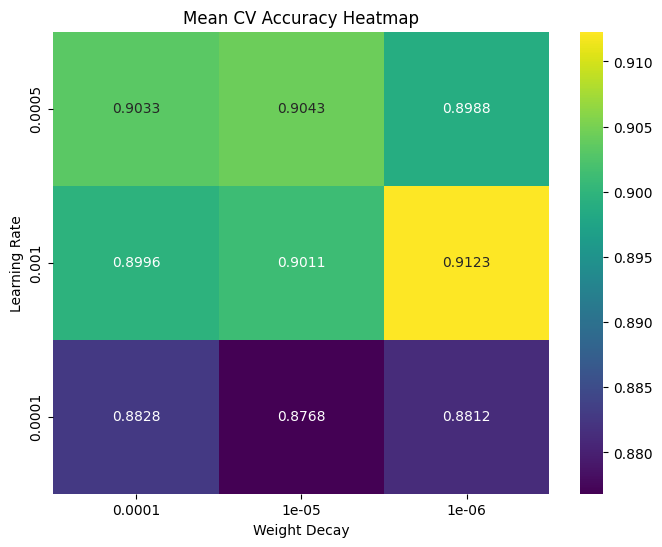

In [16]:
# Δημιουργούμε heatmap για το μοντέλο του cross validation
plt.figure(figsize=(8, 6))
sns.heatmap(
    mean_acc, 
    annot=True,          # εμφανίζει τις τιμές πάνω στο heatmap
    fmt=".4f",           # format των αριθμών
    xticklabels=params["weight_rl"],
    yticklabels=params["lr"],
    cmap="viridis"       # χρωματική κλίμακα
)
plt.xlabel("Weight Decay")
plt.ylabel("Learning Rate")
plt.title("Mean CV Accuracy Heatmap")
plt.show()


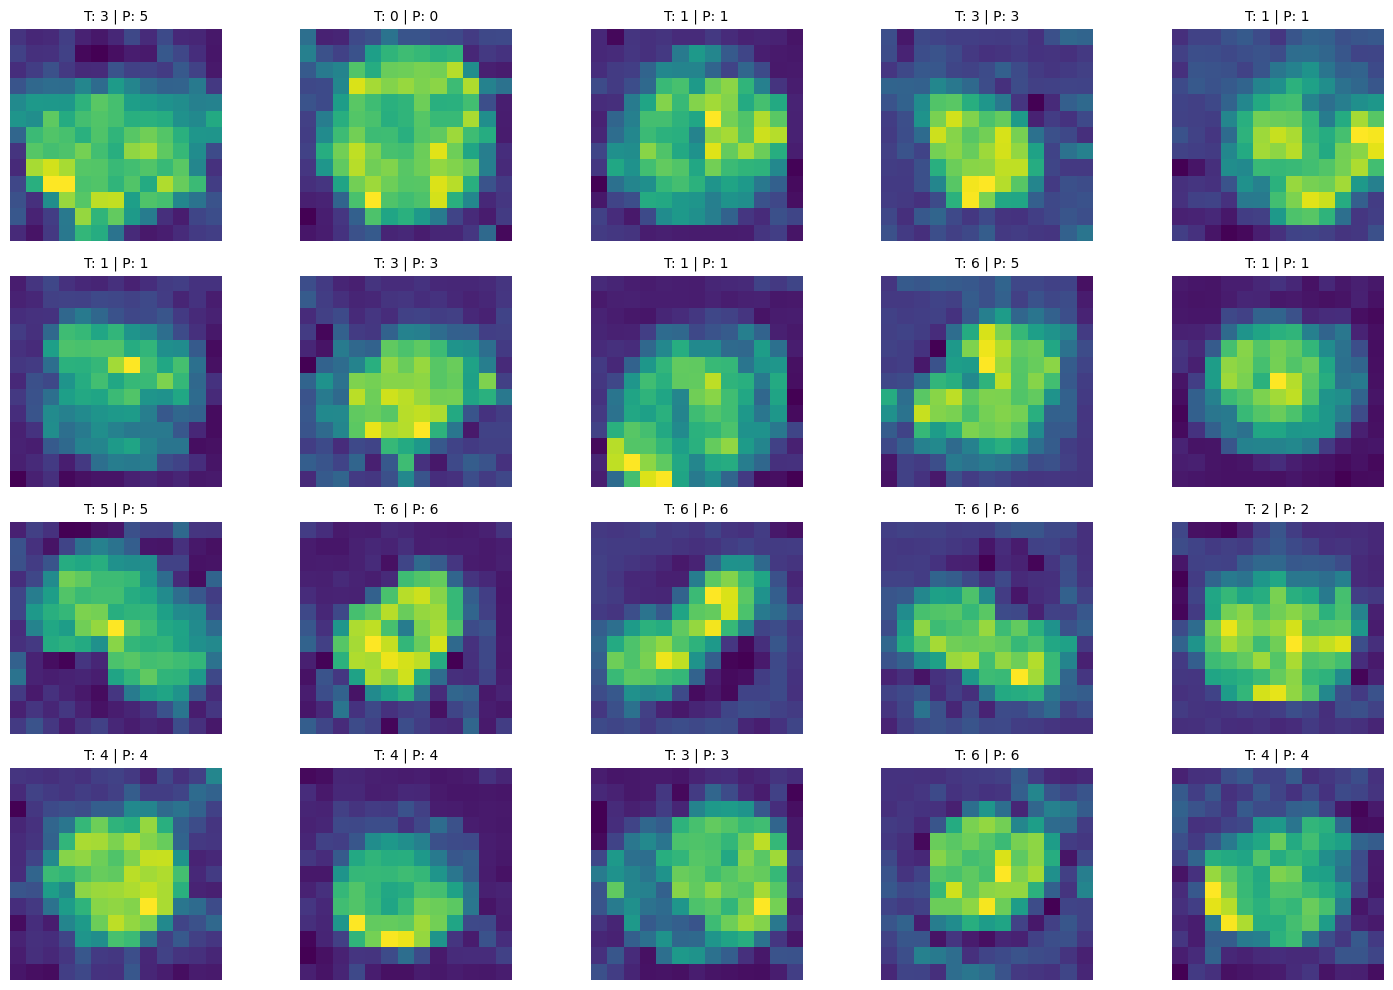

In [17]:
model.eval()  # Θέτει το μοντέλο σε evaluation mode (π.χ. απενεργοποιεί dropout)

n_images = 20
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Δημιουργία grid για εικόνες

for i in range(n_images):
    input1 = X_test[i:i+1]  # Επιλογή μιας εικόνας από το test set

    # --- Forward pass μέχρι το πρώτο conv layer και pooling ---
    x = model.pool(F.relu(model.bn1(model.conv1(input1))))
    #x = model.pool(F.relu(model.bn2(model.conv2(x))))  # Σχολιασμένο, δεν χρησιμοποιείται

    # --- Υπολογισμός mean feature map ---
    mean_map = x[0].mean(dim=0)  

    # --- Normalize για visualization ---
    mean_map = mean_map - mean_map.min()
    mean_map = mean_map / (mean_map.max() + 1e-8)

    # --- Prediction της εικόνας ---
    with torch.no_grad():
        pred = torch.argmax(model(input1), dim=1).item()

    true_label = y_test[i, 0].item()  # Πραγματική ετικέτα

    ax = axes.flat[i]
    ax.imshow(mean_map.detach().cpu())  # Προβολή του mean feature map
    ax.set_title(f"T: {true_label} | P: {pred}", fontsize=10)
    ax.axis("off")  # Απενεργοποίηση αξόνων

# --- Απενεργοποίηση τυχόν κενών subplots ---
for ax in axes.flat[n_images:]:
    ax.axis("off")

plt.tight_layout()  # Ομαλή διάταξη subplots
plt.show()


In [18]:
# Δημιουργία 7 διαφορετικών μοντέλων με παραμετροποίηση Conv layers, hidden units, και pool size
model1 = CnnNet1(16,32,128,3,2,2,84,400,100,2,2).to(device)
model2 = CnnNet1(32,64,128,3,3,3,84,400,100,2,2).to(device)
model3 = CnnNet(16,32,64,3,2,2,84,128,48,2,2).to(device)
model4 = CnnNet2(32,64,128,3,2,2,84,450,150,2,2).to(device)  # περιέχει dropout p=0.485
model5 = CnnNet(16,64,128,3,3,3,84,500,150,2,2).to(device)
model6 = CnnNet(16,64,128,3,2,2,84,450,150,2,2).to(device)
model7 = CnnNet3(32,64,128,3,2,2,84,128,48,2,2).to(device)
# Σημείωση: όλα τα μοντέλα μεταφέρονται στο επιλεγμένο device (CPU ή GPU)


In [19]:
# --- Ορισμός διαφορετικών Adam optimizers για κάθε μοντέλο με διαφορετικά learning rates, weight decay και betas ---
learning_rate1 = 0.0008
optim_adam1 = optimizer.Adam(model1.parameters(), lr=learning_rate1, weight_decay=2*1e-5, betas=(0.9,0.995))

learning_rate2 = 0.001
optim_adam2 = optimizer.Adam(model2.parameters(), lr=learning_rate2, weight_decay=2*1e-5, betas=(0.9,0.996))

learning_rate3 = 0.0008
optim_adam3 = optimizer.Adam(model3.parameters(), lr=learning_rate3, weight_decay=5*1e-5, betas=(0.9,0.9999))

learning_rate4 = 0.001
optim_adam4 = optimizer.Adam(model4.parameters(), lr=learning_rate4, weight_decay=2*1e-5, betas=(0.9,0.9995))

learning_rate5 = 0.00075
optim_adam5 = optimizer.Adam(model5.parameters(), lr=learning_rate5, weight_decay=1e-5, betas=(0.9,0.9995))

learning_rate6 = 0.001
optim_adam6 = optimizer.Adam(model6.parameters(), lr=learning_rate6, weight_decay=2*1e-5, betas=(0.9,0.9995))

learning_rate7 = 0.001
optim_adam7 = optimizer.Adam(model7.parameters(), lr=learning_rate7, weight_decay=1*1e-6, betas=(0.9,0.996))


In [20]:
# --- Ορισμός scheduler ReduceLROnPlateau για επιλεγμένα μοντέλα ---
scheduler2 = ReduceLROnPlateau(
        optimizer = optim_adam2,  # Σχετίζεται με model2
        min_lr = 1e-6,             # Ελάχιστο learning rate
        mode = "min",              # Παρακολουθεί το min (π.χ. validation loss)
        factor = 0.6,              # Ποσοστό μείωσης LR όταν plateau
        patience = 4,              # Εποχές υπομονής πριν εφαρμοστεί η μείωση
        threshold = 0.008          # Όριο για να θεωρηθεί improvement
)

scheduler4 = ReduceLROnPlateau(
        optimizer = optim_adam4,  # Σχετίζεται με model4
        min_lr = 1e-6,
        mode = "min",
        factor = 0.6,
        patience = 4,
        threshold = 0.007
)

scheduler6 = ReduceLROnPlateau(
        optimizer = optim_adam6,  # Σχετίζεται με model6
        min_lr = 1e-6,
        mode = "min",
        factor = 0.75,
        patience = 4,
        threshold = 0.007
)
# Σημείωση: Αυτοί οι schedulers μειώνουν το learning rate όταν η validation loss δεν βελτιώνεται


In [21]:
# --- Εκπαίδευση όλων των μοντέλων με καθορισμένες εποχές, batch size, optimizer και scheduler ---
history1, val_loss1, accracys_training1, accracys_validation1 = training_loop(
    Model=model1, Optimizer=optim_adam1, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=45, batch_size=128, criterion=criterion, scheduling=None
)

history2, val_loss2, accracys_training2, accracys_validation2 = training_loop(
    Model=model2, Optimizer=optim_adam2, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=45, batch_size=128, criterion=criterion, scheduling=scheduler2
)

history3, val_loss3, accracys_training3, accracys_validation3 = training_loop(
    Model=model3, Optimizer=optim_adam3, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=100, batch_size=128, criterion=criterion, scheduling=None
)

history4, val_loss4, accracys_training4, accracys_validation4 = training_loop(
    Model=model4, Optimizer=optim_adam4, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=50, batch_size=128, criterion=criterion, scheduling=scheduler4
)

history5, val_loss5, accracys_training5, accracys_validation5 = training_loop(
    Model=model5, Optimizer=optim_adam5, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=50, batch_size=128, criterion=criterion, scheduling=None
)

history6, val_loss6, accracys_training6, accracys_validation6 = training_loop(
    Model=model6, Optimizer=optim_adam6, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=50, batch_size=128, criterion=criterion, scheduling=scheduler6
)

history7, val_loss7, accracys_training7, accracys_validation7 = training_loop(
    Model=model7, Optimizer=optim_adam7, X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, epochs=50, batch_size=64, criterion=criterion, scheduling=None
)


Epoch [1/45], Loss: 5.0314, Val Loss: 1.0091, Train Acc: 0.6235, Val Acc: 0.6308
Epoch [2/45], Loss: 0.9269, Val Loss: 0.7801, Train Acc: 0.6989, Val Acc: 0.7085
Epoch [3/45], Loss: 0.6862, Val Loss: 0.6790, Train Acc: 0.7409, Val Acc: 0.7366
Epoch [4/45], Loss: 0.6700, Val Loss: 0.5522, Train Acc: 0.7716, Val Acc: 0.7798
Epoch [5/45], Loss: 0.5764, Val Loss: 0.6073, Train Acc: 0.7899, Val Acc: 0.7944
Epoch [6/45], Loss: 0.5139, Val Loss: 0.5519, Train Acc: 0.7961, Val Acc: 0.7944
Epoch [7/45], Loss: 0.4983, Val Loss: 0.4673, Train Acc: 0.8198, Val Acc: 0.8137
Epoch [8/45], Loss: 0.4813, Val Loss: 0.4037, Train Acc: 0.8417, Val Acc: 0.8440
Epoch [9/45], Loss: 0.4052, Val Loss: 0.3555, Train Acc: 0.8686, Val Acc: 0.8639
Epoch [10/45], Loss: 0.4182, Val Loss: 0.3580, Train Acc: 0.8629, Val Acc: 0.8604
Epoch [11/45], Loss: 0.3779, Val Loss: 0.3445, Train Acc: 0.8700, Val Acc: 0.8680
Epoch [12/45], Loss: 0.3695, Val Loss: 0.3810, Train Acc: 0.8496, Val Acc: 0.8440
Epoch [13/45], Loss: 0.35

In [41]:
import numpy as np

# --- Θέτει όλα τα μοντέλα σε evaluation mode ---
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()
model6.eval()
model7.eval()

accuracy_test = 0

with torch.no_grad():  # Απενεργοποίηση gradient computation για inference
    # --- Forward pass όλων των μοντέλων στο test set ---
    outputs1 = model1(X_test)
    outputs2 = model2(X_test)
    outputs3 = model3(X_test)
    outputs4 = model4(X_test)
    outputs5 = model5(X_test)
    outputs6 = model6(X_test)
    outputs7 = model7(X_test)

    # --- Μέσος όρος των εξόδων για ensemble ---
    new_outputs = (1/7) * (outputs1 + outputs2 + outputs3 + outputs4 + outputs5 + outputs6 + outputs7)

    # --- Softmax για πιθανότητες και επιλογή predicted class ---
    predictions = F.softmax(new_outputs, dim=1)
    predictions = torch.argmax(predictions, dim=1)

    # --- Υπολογισμός accuracy ---
    accuracy_test = (predictions == y_test[:,0]).float().mean()

print(accuracy_test)  # Εκτύπωση συνολικού accuracy του ensemble


tensor(0.9635)


Class 0: Precision=0.951, Recall=0.959, F1=0.955
Class 1: Precision=0.998, Recall=0.992, F1=0.995
Class 2: Precision=0.983, Recall=0.945, F1=0.964
Class 3: Precision=0.898, Recall=0.927, F1=0.912
Class 4: Precision=0.963, Recall=0.955, F1=0.959
Class 5: Precision=0.948, Recall=0.905, F1=0.926
Class 6: Precision=0.970, Recall=0.980, F1=0.975
Class 7: Precision=0.994, Recall=1.000, F1=0.997


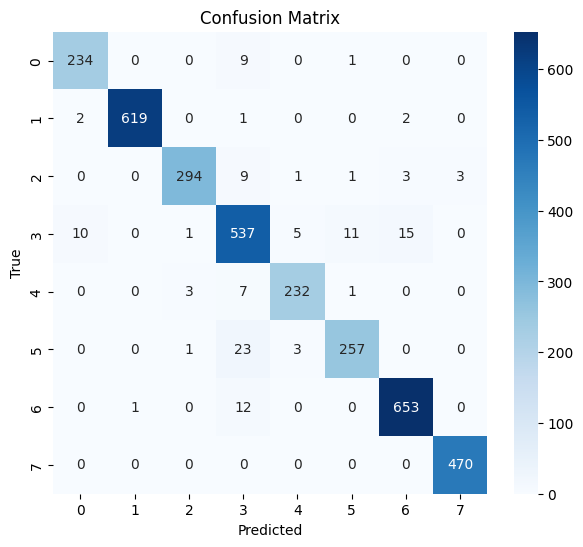

In [23]:
num_classes = 8
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int32)

# --- Γέμισμα του confusion matrix ---
for i in range(len(y_test)):
    true_label = int(y_test[i, 0])
    pred_label = int(predictions[i])
    confusion_matrix[true_label, pred_label] += 1   # True -> γραμμή, Pred -> στήλη

# --- Μετατροπή σε numpy για υπολογισμούς ---
cm1 = confusion_matrix.numpy()
cm = confusion_matrix.numpy().astype(float)
num_classes = cm.shape[0]

precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1 = np.zeros(num_classes)

# --- Υπολογισμός precision, recall και F1 για κάθε κλάση ---
for i in range(num_classes):
    TP = cm[i, i]                    # True Positives
    FP = cm[:, i].sum() - TP         # False Positives
    FN = cm[i, :].sum() - TP         # False Negatives

    precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# --- Εκτύπωση metrics ανά κλάση ---
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

# --- Plot confusion matrix με heatmap ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


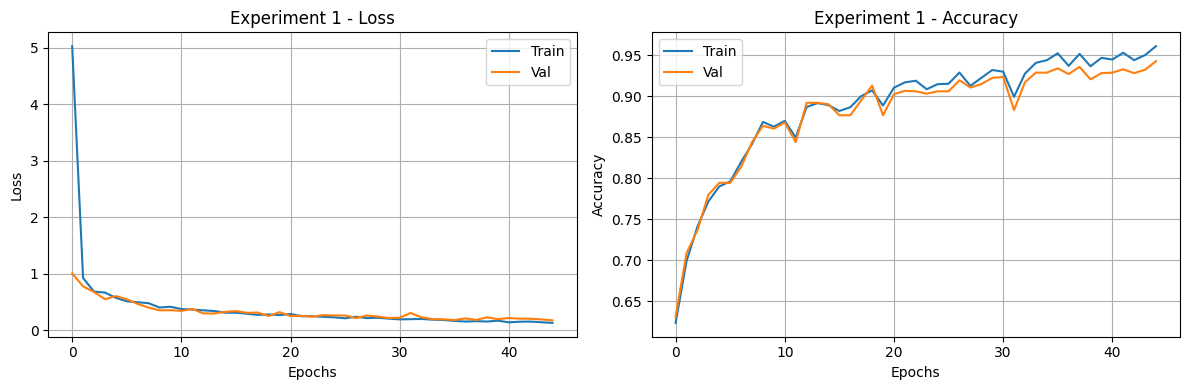

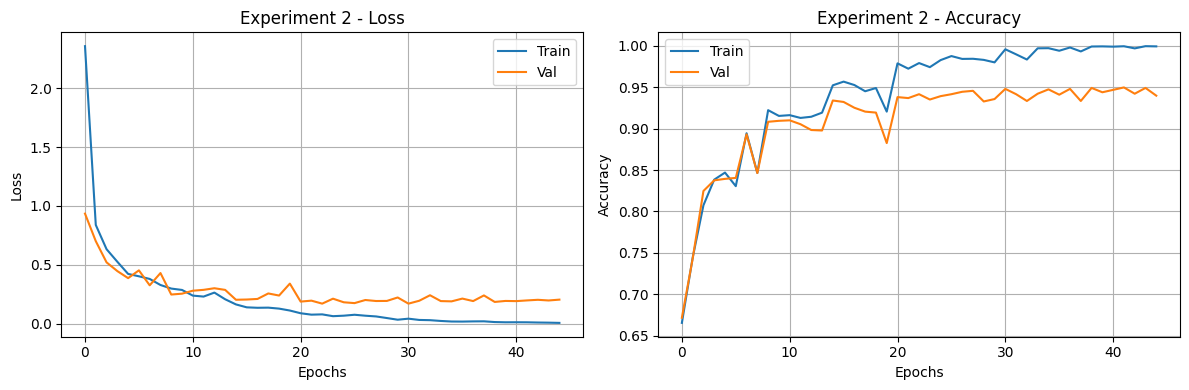

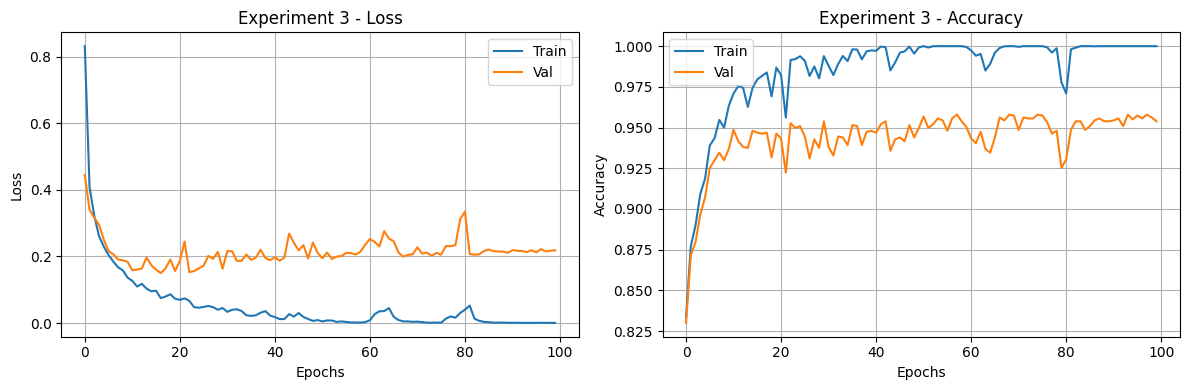

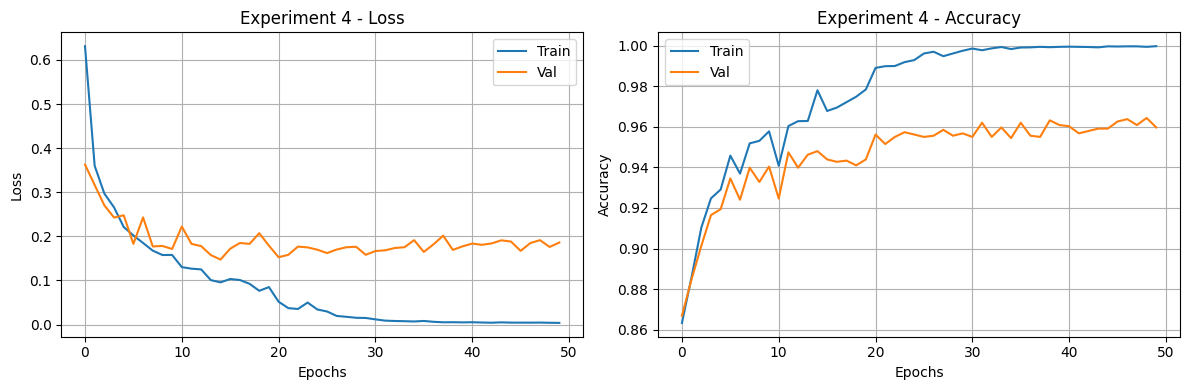

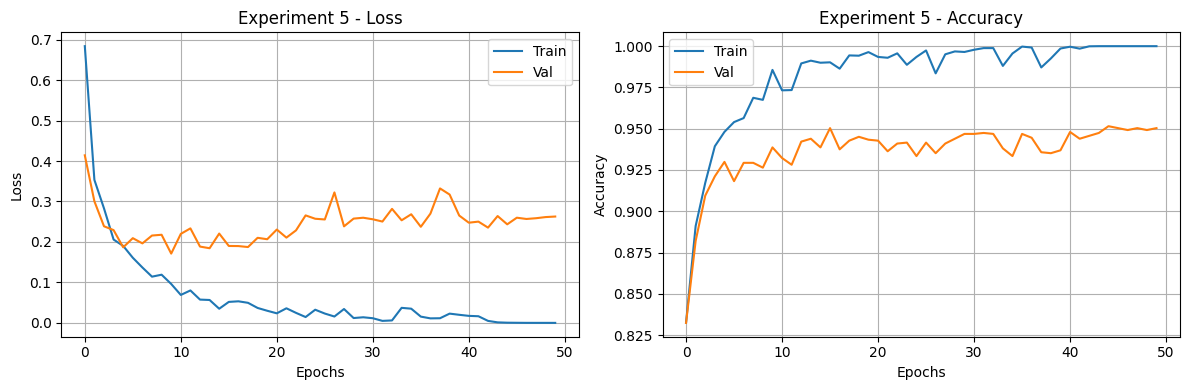

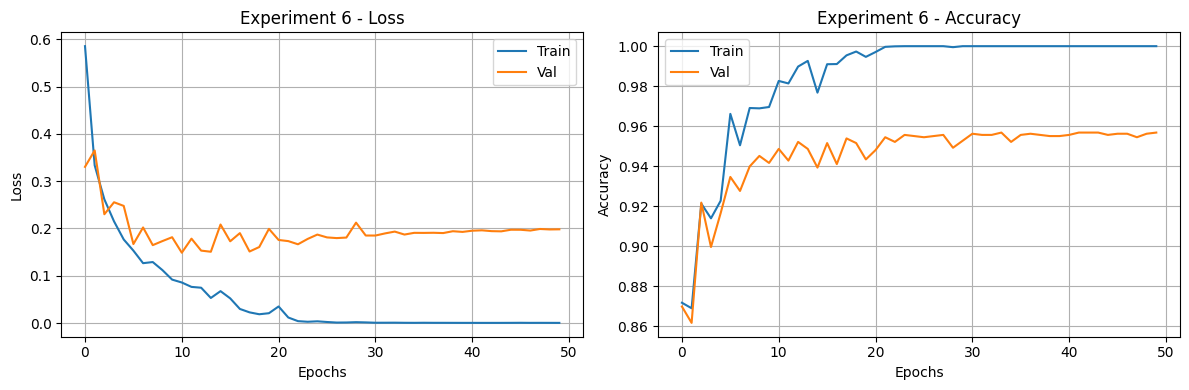

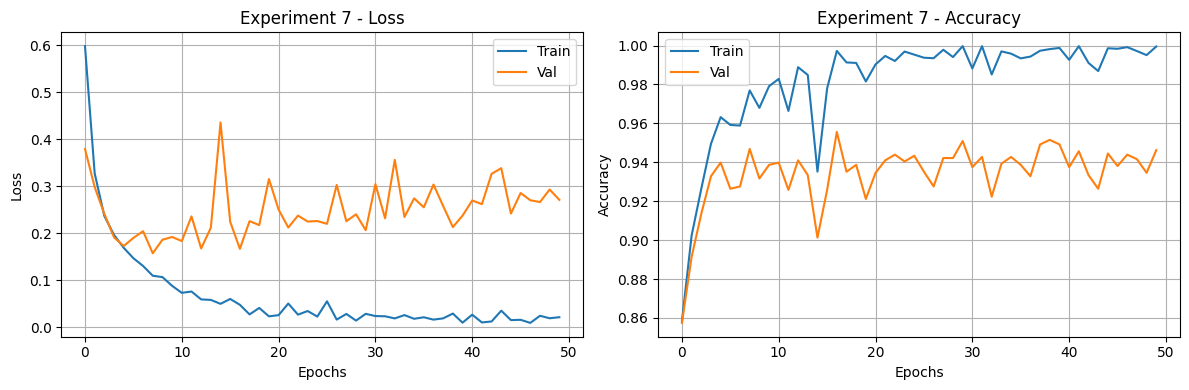

In [24]:
# --- Οργάνωση ιστορικών δεδομένων για όλα τα πειράματα ---
history_list = [history1, history2, history3, history4, history5, history6, history7]
val_loss_list = [val_loss1, val_loss2, val_loss3, val_loss4, val_loss5, val_loss6, val_loss7]
accracys_training_list = [accracys_training1, accracys_training2, accracys_training3, accracys_training4, accracys_training5, accracys_training6, accracys_training7]
accracys_validation_list = [accracys_validation1, accracys_validation2, accracys_validation3, accracys_validation4, accracys_validation5, accracys_validation6, accracys_validation7]

# --- Plotting loss και accuracy για κάθε πείραμα ---
for i in range(7):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # --- Loss plot ---
    axes[0].plot(history_list[i])        # Training loss
    axes[0].plot(val_loss_list[i])      # Validation loss
    axes[0].set_title(f'Experiment {i+1} - Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend(['Train', 'Val'])
    axes[0].grid(True)

    # --- Accuracy plot ---
    axes[1].plot(accracys_training_list[i])      # Training accuracy
    axes[1].plot(accracys_validation_list[i])   # Validation accuracy
    axes[1].set_title(f'Experiment {i+1} - Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(['Train', 'Val'])
    axes[1].grid(True)

    plt.tight_layout()  # Ομαλή διάταξη subplots
    plt.show()
